In [3]:
!pip install prophet
!pip install gdown
!pip install easygui

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   --- ------------------------------------ 1.3/13.3 MB 9.5 MB/s eta 0:00:02
   ------ --------------------------------- 2.1/13.3 MB 10.7 MB/s eta 0:00:02
   ------------ --------------------------- 4.2/13.3 MB 9.3 MB/s eta 0:00:01
   ------------------------- -------------- 8.7/13.3 MB 11.2 MB/s eta 0:00:01
   ----------------------------------- ---- 11.8/13.3 MB 11.9 MB/s eta 0:00:01
   ---------------------------------------  13.1/13.3 MB 12.4 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 9.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 17.2 MB/s eta 0:00:00


# **UPLOAD file AND GET MODEL**

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up seaborn for better plots
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Define required columns and their types
required_columns = {
    'season': 'object',
    'Year': 'float64',
    'Month': 'float64',
    'SSalD_Dist_Code': 'int64',
    'SSalD_Cust_ID': 'float64',
    'Prd_SAP_Code': 'int64',
    'Total_Quantity': 'float64',
    'Total_Value': 'float64',
    'Total_Bonus': 'float64',
    'Total_Discount': 'float64',
    'Total_DP': 'float64',
    'Total_TP': 'float64',
    'Total_MRP': 'float64'
}

def process_file(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Check if columns match the required columns
    missing_cols = set(required_columns.keys()) - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing columns: {', '.join(missing_cols)}")

    for col, dtype in required_columns.items():
        if df[col].dtype != dtype:
            raise ValueError(f"Column '{col}' does not have the correct dtype. Expected {dtype}, got {df[col].dtype}")

    # Preprocessing
    df['Year'] = df['Year'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01', format='%Y-%m-%d')
    df.set_index('Date', inplace=True)

    # Prepare data for Prophet
    prophet_df = df.reset_index()[['Date', 'Total_Quantity']]
    prophet_df.columns = ['ds', 'y']

    # Remove duplicate dates if they exist
    prophet_df = prophet_df.drop_duplicates(subset=['ds'])

    # Add cap and floor to prevent negative forecasts
    prophet_df['cap'] = df['Total_Quantity'].max()  # Upper bound cap
    prophet_df['floor'] = 0  # Lower bound

    # Fit the Prophet model with logistic growth
    prophet_model = Prophet(growth='logistic')
    prophet_model.fit(prophet_df)

    # Forecast the next 1 year (12 months)
    future = prophet_model.make_future_dataframe(periods=29, freq='M')
    future['cap'] = df['Total_Quantity'].max()  # Apply the same cap to future
    future['floor'] = 0  # Apply the same floor to future
    forecast = prophet_model.predict(future)

    # Combine the forecast with actual values
    forecast_full = forecast[['ds', 'yhat']].copy()
    forecast_full = forecast_full.rename(columns={'yhat': 'Forecasted_Quantity'})
    forecast_full = forecast_full.merge(prophet_df, on='ds', how='left')
    forecast_full = forecast_full.rename(columns={'y': 'Actual_Quantity'})
    
    # Ensure the directory for saving images exists
    images_dir = './Saved_images/'
    if not os.path.exists(images_dir):
        os.makedirs(images_dir)

    # Save the forecast line plot
    plot_path = f"{images_dir}forecast_{os.path.basename(file_path).split('.')[0]}.png"
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=prophet_df, x='ds', y='y', label='Historical Data', color='blue', marker='o', linewidth=2)
    sns.lineplot(data=forecast, x='ds', y='yhat', label='Prophet Forecast', color='red', linestyle='--', marker='x', linewidth=2)
    plt.title('Actual vs Forecasted Total Quantity', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Total Quantity', fontsize=12)
    plt.legend(loc='upper left', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.close()

    # Pie Chart for Forecasted Total Quantity by Year
    forecast_full['Year'] = pd.to_datetime(forecast_full['ds']).dt.year
    forecast_per_year = forecast_full.groupby('Year')['Forecasted_Quantity'].sum()

    # Plot a single pie chart for forecasted data by year
    pie_chart_path = f"{images_dir}forecast_pie_chart_{os.path.basename(file_path).split('.')[0]}.png"
    plt.figure(figsize=(8, 8))
    plt.pie(forecast_per_year, labels=forecast_per_year.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    plt.title('Forecasted Total Quantity Proportion by Year', fontsize=16)
    plt.tight_layout()
    plt.savefig(pie_chart_path)
    plt.close()

    # Bar Chart for Forecasted Total Quantity by Year
    bar_chart_path = f"{images_dir}forecast_bar_chart_{os.path.basename(file_path).split('.')[0]}.png"
    plt.figure(figsize=(10, 6))
    sns.barplot(x=forecast_per_year.index, y=forecast_per_year.values, palette="viridis")
    plt.title('Total Forecasted Quantity by Year', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Total Forecasted Quantity', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()
    plt.savefig(bar_chart_path)
    plt.close()

    # Return the full forecast DataFrame with both forecasted and actual values
    return forecast_full

# Example usage
file_path = 'dataset_10000923.csv'  # Replace with your CSV file path
forecast_full_df = process_file(file_path)

# Display the forecasted DataFrame
print(forecast_full_df)

11:23:33 - cmdstanpy - INFO - Chain [1] start processing
11:23:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
C:\Users\Abdur Raffay Khan\AppData\Local\Temp\ipykernel_8592\3560524725.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=forecast_per_year.index, y=forecast_per_year.values, palette="viridis")


           ds  Forecasted_Quantity  Actual_Quantity     cap  floor  Year
0  2022-01-01           -89.767366            200.0  4488.0    0.0  2022
1  2022-02-01           235.248681            263.0  4488.0    0.0  2022
2  2022-03-01           200.913097             50.0  4488.0    0.0  2022
3  2022-04-01           806.494361             45.0  4488.0    0.0  2022
4  2022-05-01           364.173986            600.0  4488.0    0.0  2022
..        ...                  ...              ...     ...    ...   ...
56 2026-08-31          3155.042407              NaN     NaN    NaN  2026
57 2026-09-30          1068.439866              NaN     NaN    NaN  2026
58 2026-10-31         -3833.455304              NaN     NaN    NaN  2026
59 2026-11-30         -1261.831353              NaN     NaN    NaN  2026
60 2026-12-31          5985.854076              NaN     NaN    NaN  2026

[61 rows x 6 columns]


# **1. Code for Product 10000019:**

10:38:12 - cmdstanpy - INFO - Chain [1] start processing
10:38:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


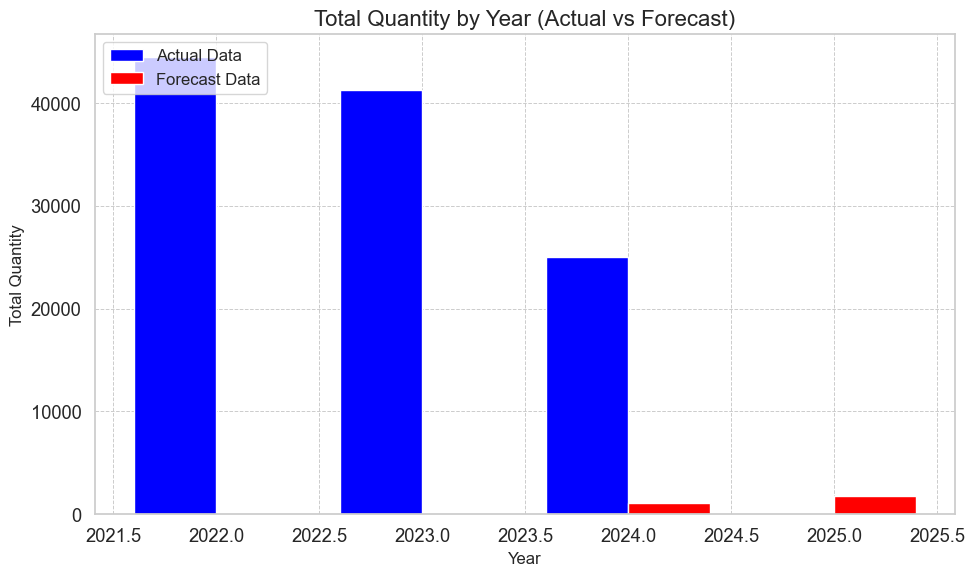

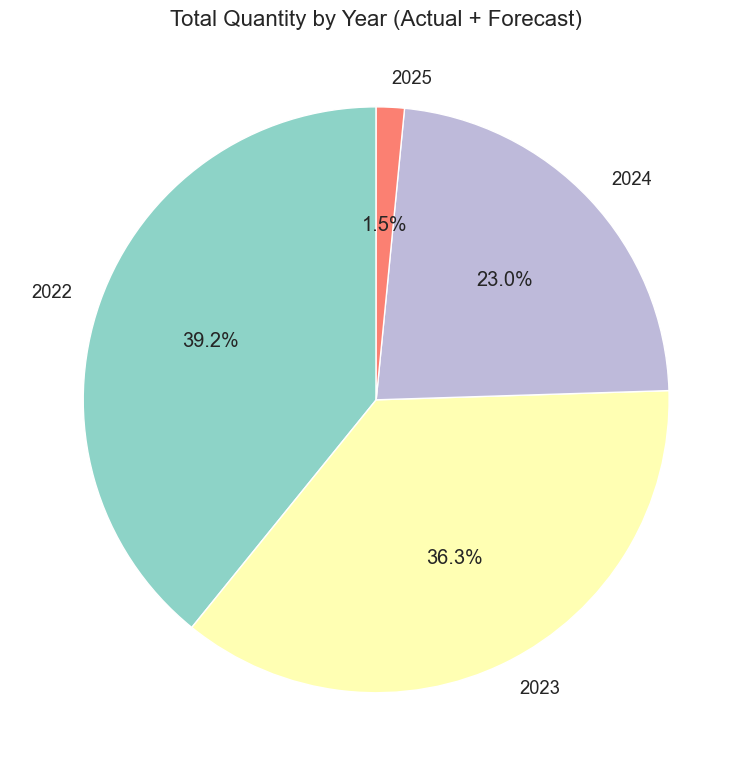

In [14]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Set up seaborn for better plots
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Define required columns and their types
required_columns = {
    'season': 'object',
    'Year': 'float64',
    'Month': 'float64',
    'SSalD_Dist_Code': 'int64',
    'SSalD_Cust_ID': 'float64',
    'Prd_SAP_Code': 'int64',
    'Total_Quantity': 'float64',
    'Total_Value': 'float64',
    'Total_Bonus': 'float64',
    'Total_Discount': 'float64',
    'Total_DP': 'float64',
    'Total_TP': 'float64',
    'Total_MRP': 'float64'
}

def train_model(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Check if columns match the required columns
    missing_cols = set(required_columns.keys()) - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing columns: {', '.join(missing_cols)}")

    for col, dtype in required_columns.items():
        if df[col].dtype != dtype:
            raise ValueError(f"Column '{col}' does not have the correct dtype. Expected {dtype}, got {df[col].dtype}")

    # Preprocessing
    df['Year'] = df['Year'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01', format='%Y-%m-%d')
    df.set_index('Date', inplace=True)

    # Prepare data for Prophet
    prophet_df = df.reset_index()[['Date', 'Total_Quantity']]
    prophet_df.columns = ['ds', 'y']

    # Fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(prophet_df)

    # Forecast the next 1 year (12 months)
    future = prophet_model.make_future_dataframe(periods=12, freq='M')
    forecast = prophet_model.predict(future)
    forecast_df = forecast[['ds', 'yhat']].tail(12).set_index('ds')
    forecast_df.columns = ['Prophet_Forecast']

    # Add Year column to forecasted and actual data
    forecast_df['Year'] = forecast_df.index.year
    prophet_df['Year'] = pd.to_datetime(prophet_df['ds']).dt.year

    # Group data by Year for both actual and forecasted, summing only the 'y' (Total_Quantity) for actual and 'Prophet_Forecast' for forecast
    actual_per_year = prophet_df.groupby('Year')['y'].sum()
    forecast_per_year = forecast_df.groupby('Year')['Prophet_Forecast'].sum()

    # Combine actual and forecasted data for pie chart
    combined_data = pd.concat([actual_per_year, forecast_per_year], axis=1, keys=['Actual', 'Forecast']).fillna(0)
    combined_data['Total'] = combined_data['Actual'] + combined_data['Forecast']

    # Plot bar plot for both forecasted and actual data
    plt.figure(figsize=(10, 6))
    plt.bar(actual_per_year.index - 0.2, actual_per_year, width=0.4, label='Actual Data', color='blue')
    plt.bar(forecast_per_year.index + 0.2, forecast_per_year, width=0.4, label='Forecast Data', color='red')

    plt.title('Total Quantity by Year (Actual vs Forecast)', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Total Quantity', fontsize=12)
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()
    plt.show()

    # Plot a single pie chart for combined actual and forecasted data by year
    plt.figure(figsize=(8, 8))
    plt.pie(combined_data['Total'], labels=combined_data.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set3', len(combined_data)))
    plt.title('Total Quantity by Year (Actual + Forecast)', fontsize=16)
    plt.tight_layout()
    plt.show()

    return prophet_model, prophet_df

# Example usage
file_path = 'dataset_10000019.csv'  # Replace with your CSV file path
prophet_model, prophet_df = train_model(file_path)

In [13]:
import pickle
import os

# Define the folder and filename for saving the model
save_folder = 'saved_models'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

model_filename = os.path.join(save_folder, 'prophet_model.pkl')

# Save the Prophet model using pickle
with open(model_filename, 'wb') as f:
    pickle.dump(prophet_model, f)

print(f"Model saved to {model_filename}")

Model saved to saved_models\prophet_model.pkl


# **2. Code for Product 10000516:**

Downloading...
From: https://drive.google.com/uc?id=1IT7kBddp-ImQGHqECzFe6K8XhF_Hvf2r
To: c:\Users\Abdur Raffay Khan\Documents\INTERNSHIP_HIGHNOON\final\dataset_10000516.csv
100%|██████████| 135k/135k [00:00<00:00, 405kB/s]
11:17:21 - cmdstanpy - INFO - Chain [1] start processing
11:17:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


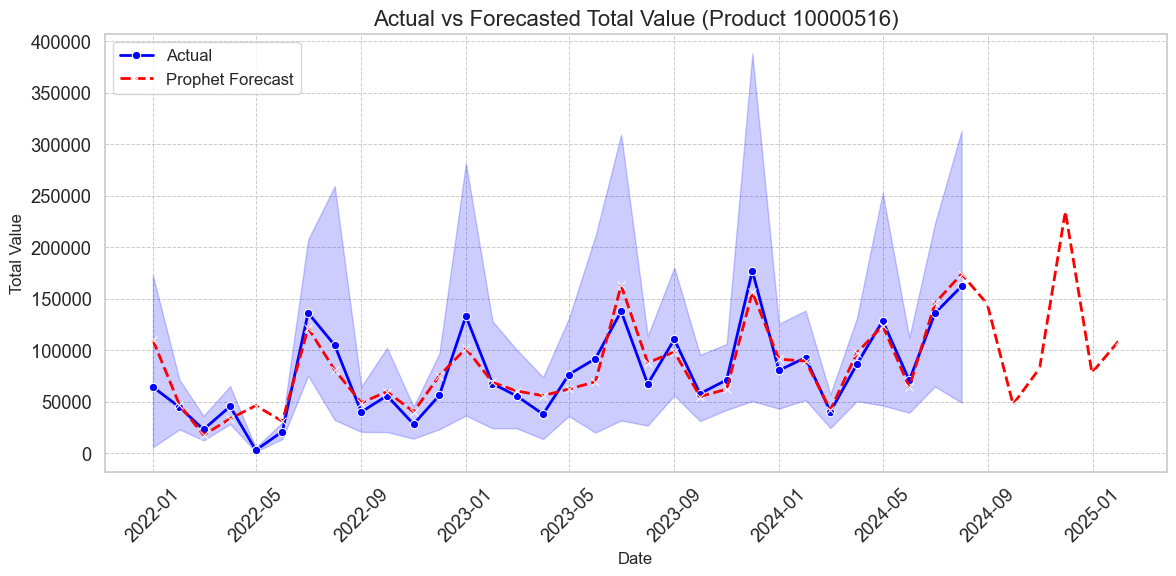

c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future ve

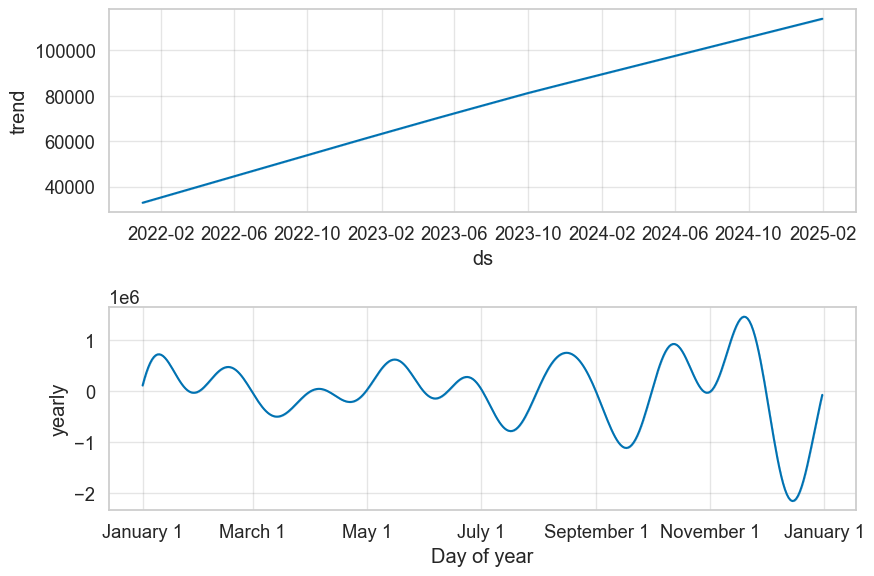

In [66]:
import gdown
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Set up seaborn for better plots
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Step 1: Download the dataset
file_url_10000516 = 'https://drive.google.com/uc?id=1IT7kBddp-ImQGHqECzFe6K8XhF_Hvf2r'
gdown.download(file_url_10000516, 'dataset_10000516.csv', quiet=False)

# Load the dataset
df_10000516 = pd.read_csv('dataset_10000516.csv')

# Preprocessing
df_10000516['Year'] = df_10000516['Year'].astype(int)
df_10000516['Month'] = df_10000516['Month'].astype(int)
df_10000516['Date'] = pd.to_datetime(df_10000516['Year'].astype(str) + '-' + df_10000516['Month'].astype(str) + '-01', format='%Y-%m-%d')
df_10000516.set_index('Date', inplace=True)

# Prepare dataset for Prophet
df_prophet = df_10000516[['Total_Value']].reset_index()
df_prophet.rename(columns={'Date': 'ds', 'Total_Value': 'y'}, inplace=True)

# Initialize and fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Forecast for the next 6 months
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)
forecast_df = forecast[['ds', 'yhat']].tail(6).set_index('ds')
forecast_df.columns = ['Prophet_Forecast']

# Plot results
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_prophet, x='ds', y='y', label='Actual', color='blue', marker='o', linewidth=2)
sns.lineplot(data=forecast, x='ds', y='yhat', label='Prophet Forecast', color='red', linestyle='--', marker='x', linewidth=2)

# Customize the plot
plt.title('Actual vs Forecasted Total Value (Product 10000516)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Value', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

# Plot forecast components (trend, weekly, yearly seasonality)
model.plot_components(forecast)
plt.show()

# **3. Code for Product 10001095:**

Downloading...
From: https://drive.google.com/uc?id=1nD6Pk0jm9PBli7eMO0Za190zndV-bhXk
To: c:\Users\Abdur Raffay Khan\Documents\INTERNSHIP_HIGHNOON\final\dataset_10001095.csv
100%|██████████| 28.0k/28.0k [00:00<00:00, 240kB/s]
11:21:22 - cmdstanpy - INFO - Chain [1] start processing
11:21:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


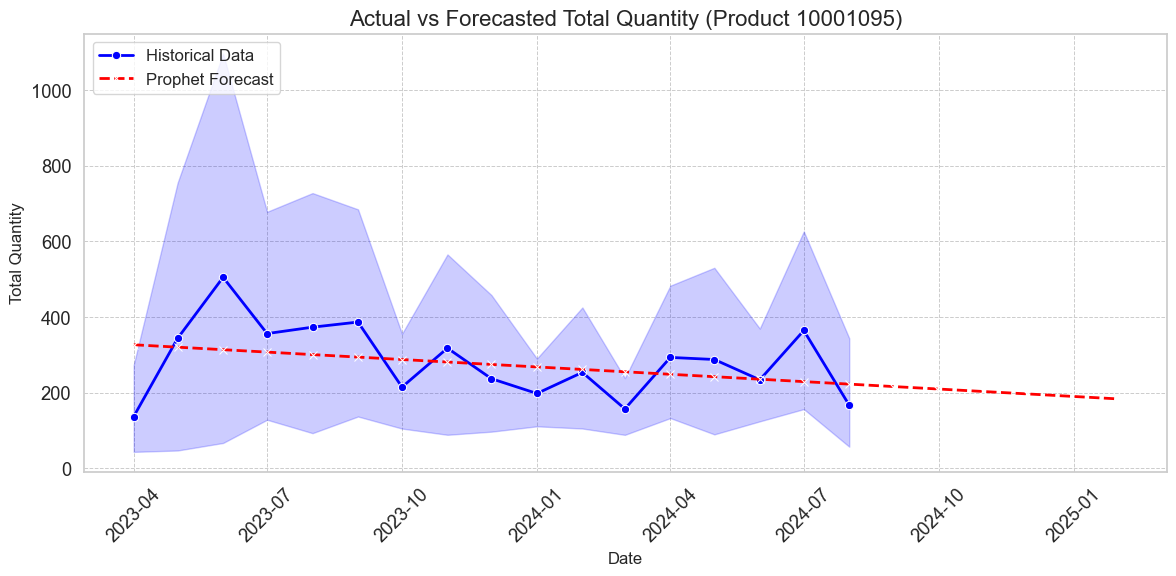

c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


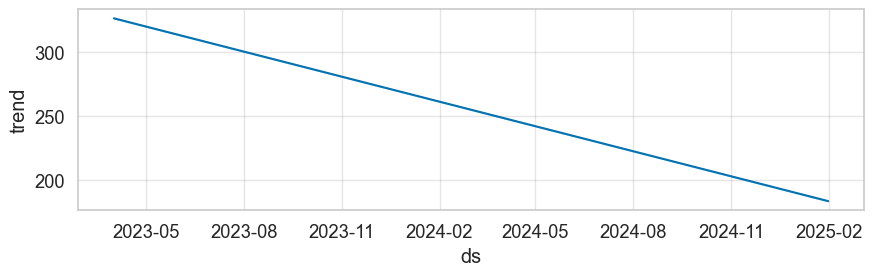

In [68]:
import gdown
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Set up seaborn for better plots
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Step 1: Download the dataset
file_url_10001095 = 'https://drive.google.com/uc?id=1nD6Pk0jm9PBli7eMO0Za190zndV-bhXk'
gdown.download(file_url_10001095, 'dataset_10001095.csv', quiet=False)

# Load the dataset
df_10001095 = pd.read_csv('dataset_10001095.csv')

# Preprocessing
df_10001095['Year'] = df_10001095['Year'].astype(int)
df_10001095['Month'] = df_10001095['Month'].astype(int)
df_10001095['Date'] = pd.to_datetime(df_10001095['Year'].astype(str) + '-' + df_10001095['Month'].astype(str) + '-01', format='%Y-%m-%d')
df_10001095.set_index('Date', inplace=True)

# Prepare data for Prophet
prophet_df = df_10001095.reset_index()[['Date', 'Total_Quantity']]
prophet_df.columns = ['ds', 'y']

# Fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Forecast the next 6 months
future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast = prophet_model.predict(future)
forecast_df = forecast[['ds', 'yhat']].tail(6).set_index('ds')
forecast_df.columns = ['Prophet_Forecast']

# Plot results
plt.figure(figsize=(12, 6))
sns.lineplot(data=prophet_df, x='ds', y='y', label='Historical Data', color='blue', marker='o', linewidth=2)
sns.lineplot(data=forecast, x='ds', y='yhat', label='Prophet Forecast', color='red', linestyle='--', marker='x', linewidth=2)

# Customize the plot
plt.title('Actual vs Forecasted Total Quantity (Product 10001095)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Quantity', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

# Plot forecast components (trend, weekly, yearly seasonality)
prophet_model.plot_components(forecast)
plt.show()

# **4. Code for Product 10000923:**

Downloading...
From: https://drive.google.com/uc?id=1JXO6F7i-9IzPOseYPq0h3ctruUx_W0ZG
To: c:\Users\Abdur Raffay Khan\Documents\INTERNSHIP_HIGHNOON\final\dataset_10000923.csv
100%|██████████| 60.6k/60.6k [00:00<00:00, 286kB/s]
11:22:24 - cmdstanpy - INFO - Chain [1] start processing
11:22:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


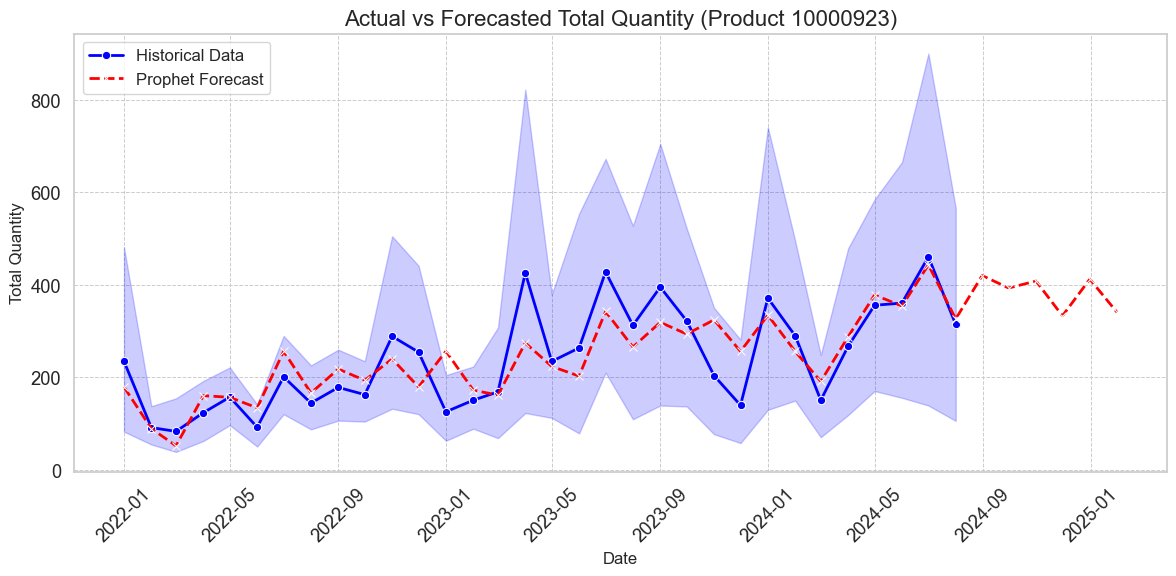

c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future ve

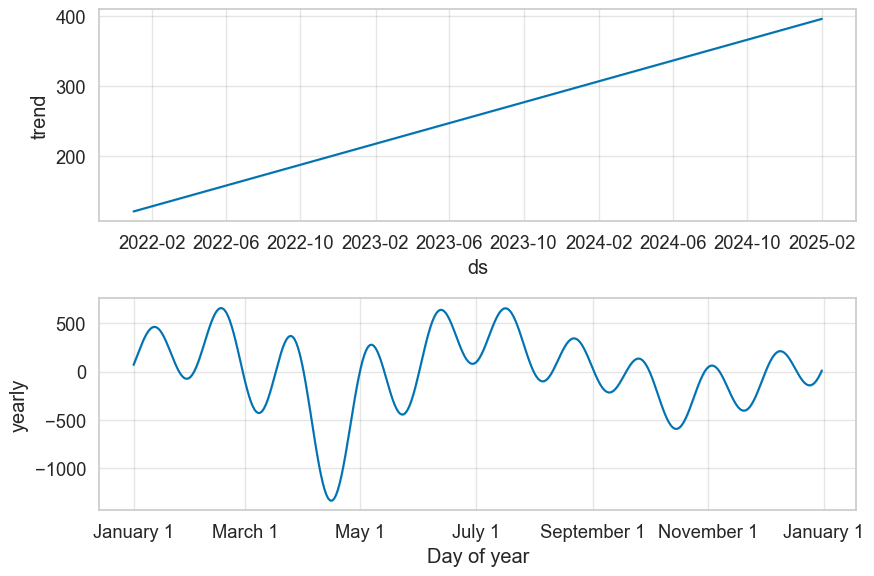

In [69]:
import gdown
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Set up seaborn for better plots
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Step 1: Download the dataset
file_url_10000923 = 'https://drive.google.com/uc?id=1JXO6F7i-9IzPOseYPq0h3ctruUx_W0ZG'
gdown.download(file_url_10000923, 'dataset_10000923.csv', quiet=False)

# Load the dataset
df_10000923 = pd.read_csv('dataset_10000923.csv')

# Preprocessing
df_10000923['Year'] = df_10000923['Year'].astype(int)
df_10000923['Month'] = df_10000923['Month'].astype(int)
df_10000923['Date'] = pd.to_datetime(df_10000923['Year'].astype(str) + '-' + df_10000923['Month'].astype(str) + '-01', format='%Y-%m-%d')
df_10000923.set_index('Date', inplace=True)

# Prepare data for Prophet
prophet_df = df_10000923.reset_index()[['Date', 'Total_Quantity']]
prophet_df.columns = ['ds', 'y']

# Fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Forecast the next 6 months
future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast = prophet_model.predict(future)
forecast_df = forecast[['ds', 'yhat']].tail(6).set_index('ds')
forecast_df.columns = ['Prophet_Forecast']

# Plot results
plt.figure(figsize=(12, 6))
sns.lineplot(data=prophet_df, x='ds', y='y', label='Historical Data', color='blue', marker='o', linewidth=2)
sns.lineplot(data=forecast, x='ds', y='yhat', label='Prophet Forecast', color='red', linestyle='--', marker='x', linewidth=2)

# Customize the plot
plt.title('Actual vs Forecasted Total Quantity (Product 10000923)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Quantity', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

# Plot forecast components (trend, weekly, yearly seasonality)
prophet_model.plot_components(forecast)
plt.show()

# **5. Code for Product 10000961:**

Downloading...
From: https://drive.google.com/uc?id=1b1e_xmrVhqrd-eK_7Ygznil_EIJGNz1c
To: c:\Users\Abdur Raffay Khan\Documents\INTERNSHIP_HIGHNOON\final\dataset_10000961.csv
100%|██████████| 82.3k/82.3k [00:00<00:00, 329kB/s]
11:23:52 - cmdstanpy - INFO - Chain [1] start processing
11:23:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


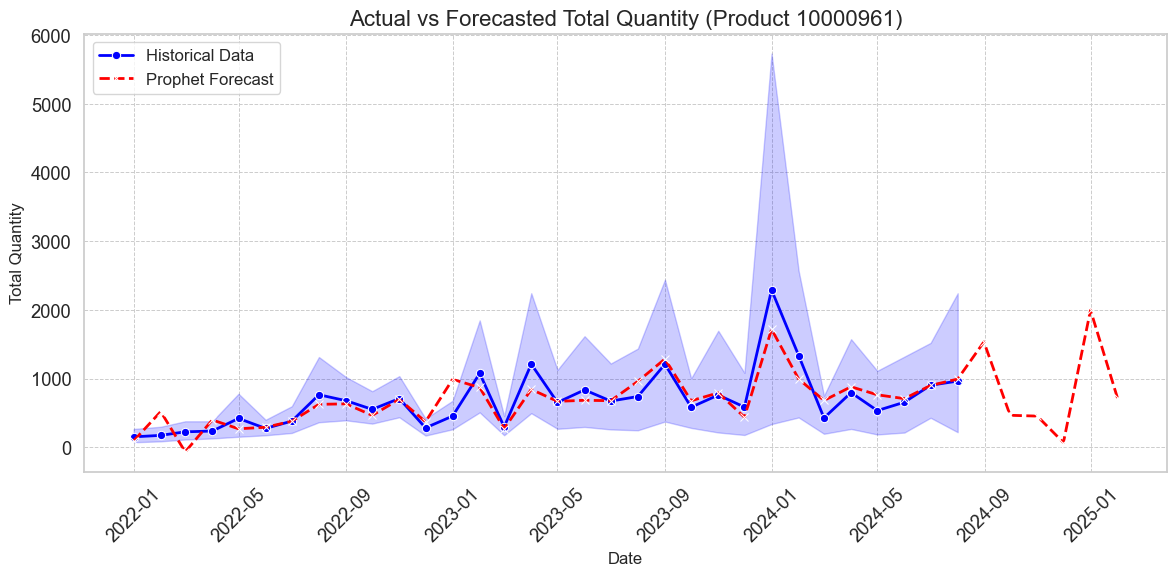

c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future ve

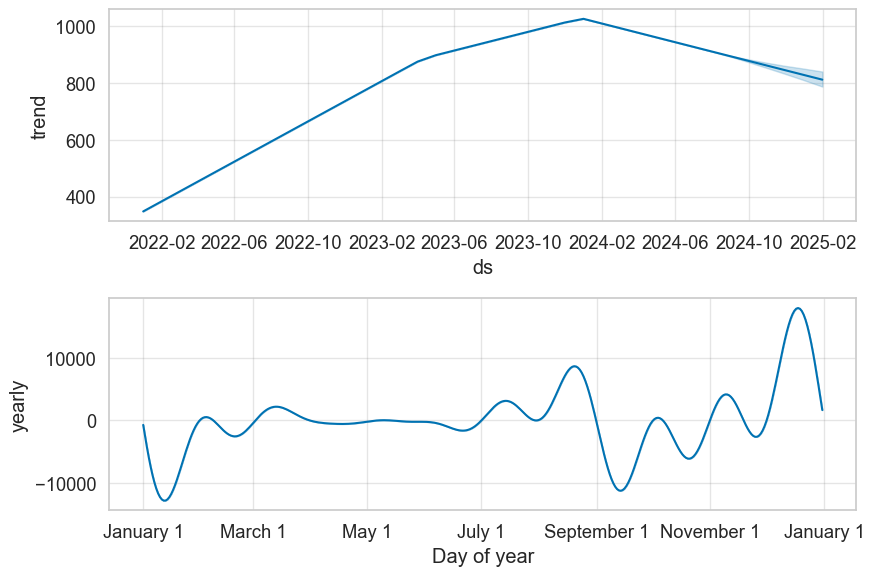

In [70]:
import gdown
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Set up seaborn for better plots
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Step 1: Download the dataset
file_url_10000961 = 'https://drive.google.com/uc?id=1b1e_xmrVhqrd-eK_7Ygznil_EIJGNz1c'
gdown.download(file_url_10000961, 'dataset_10000961.csv', quiet=False)

# Load the dataset
df_10000961 = pd.read_csv('dataset_10000961.csv')

# Preprocessing
df_10000961['Year'] = df_10000961['Year'].astype(int)
df_10000961['Month'] = df_10000961['Month'].astype(int)
df_10000961['Date'] = pd.to_datetime(df_10000961['Year'].astype(str) + '-' + df_10000961['Month'].astype(str) + '-01', format='%Y-%m-%d')
df_10000961.set_index('Date', inplace=True)

# Prepare data for Prophet
prophet_df = df_10000961.reset_index()[['Date', 'Total_Quantity']]
prophet_df.columns = ['ds', 'y']

# Fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Forecast the next 6 months
future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast = prophet_model.predict(future)
forecast_df = forecast[['ds', 'yhat']].tail(6).set_index('ds')
forecast_df.columns = ['Prophet_Forecast']

# Plot results
plt.figure(figsize=(12, 6))
sns.lineplot(data=prophet_df, x='ds', y='y', label='Historical Data', color='blue', marker='o', linewidth=2)
sns.lineplot(data=forecast, x='ds', y='yhat', label='Prophet Forecast', color='red', linestyle='--', marker='x', linewidth=2)

# Customize the plot
plt.title('Actual vs Forecasted Total Quantity (Product 10000961)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Quantity', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

# Plot forecast components (trend, weekly, yearly seasonality)
prophet_model.plot_components(forecast)
plt.show()

# **6. Code for Product 10000181:**

Downloading...
From: https://drive.google.com/uc?id=1fYoR8hUAK9vNw6l-onnQp0kP8ekx4t4u
To: c:\Users\Abdur Raffay Khan\Documents\INTERNSHIP_HIGHNOON\final\dataset_10000181.csv
100%|██████████| 116k/116k [00:00<00:00, 365kB/s]
11:25:08 - cmdstanpy - INFO - Chain [1] start processing
11:25:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


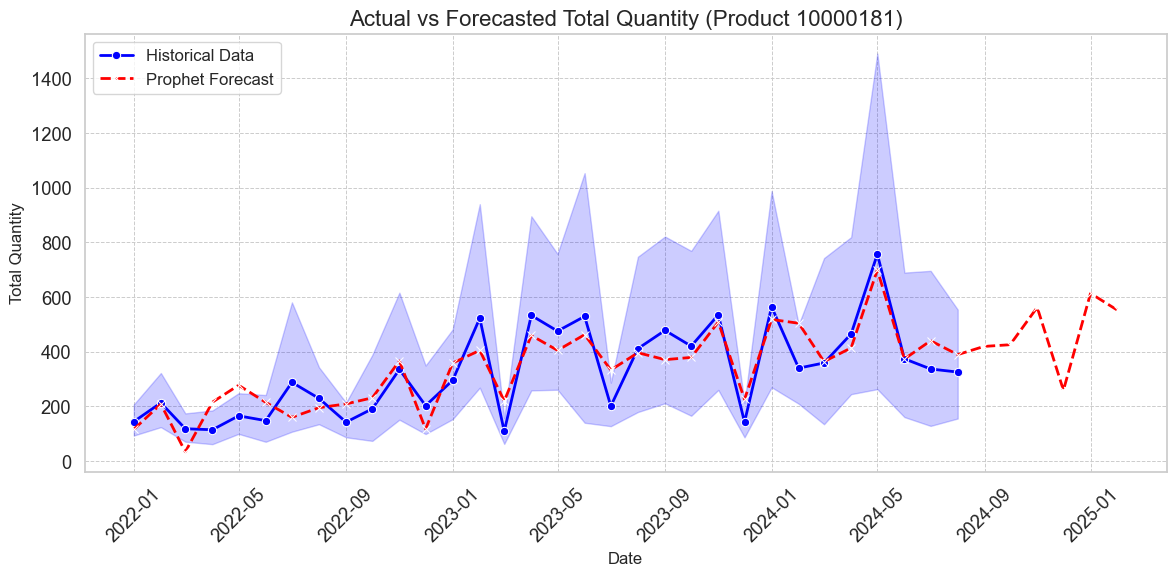

c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future ve

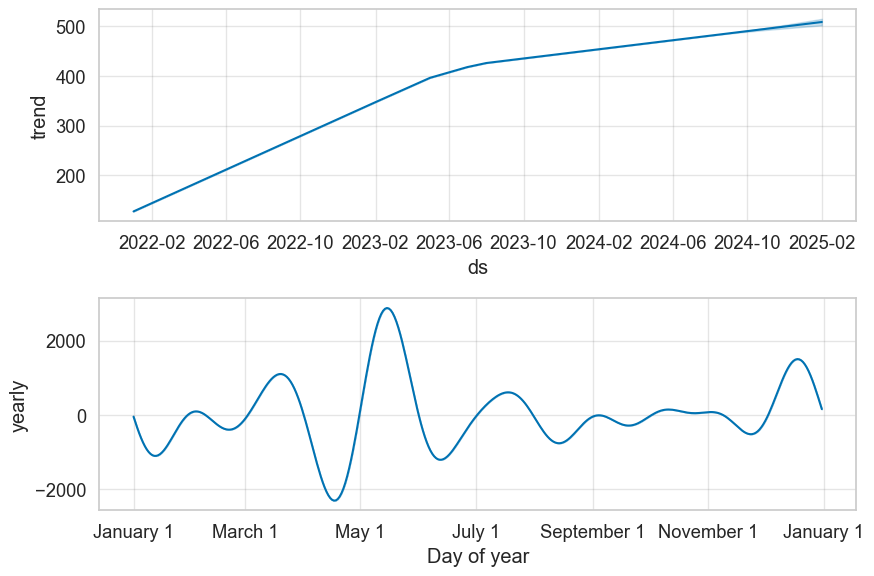

In [71]:
import gdown
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Set up seaborn for better plots
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Step 1: Download the dataset
file_url_10000181 = 'https://drive.google.com/uc?id=1fYoR8hUAK9vNw6l-onnQp0kP8ekx4t4u'
gdown.download(file_url_10000181, 'dataset_10000181.csv', quiet=False)

# Load the dataset
df_10000181 = pd.read_csv('dataset_10000181.csv')

# Preprocessing
df_10000181['Year'] = df_10000181['Year'].astype(int)
df_10000181['Month'] = df_10000181['Month'].astype(int)
df_10000181['Date'] = pd.to_datetime(df_10000181['Year'].astype(str) + '-' + df_10000181['Month'].astype(str) + '-01', format='%Y-%m-%d')
df_10000181.set_index('Date', inplace=True)

# Prepare data for Prophet
prophet_df = df_10000181.reset_index()[['Date', 'Total_Quantity']]
prophet_df.columns = ['ds', 'y']

# Fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Forecast the next 6 months
future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast = prophet_model.predict(future)
forecast_df = forecast[['ds', 'yhat']].tail(6).set_index('ds')
forecast_df.columns = ['Prophet_Forecast']

# Plot results
plt.figure(figsize=(12, 6))
sns.lineplot(data=prophet_df, x='ds', y='y', label='Historical Data', color='blue', marker='o', linewidth=2)
sns.lineplot(data=forecast, x='ds', y='yhat', label='Prophet Forecast', color='red', linestyle='--', marker='x', linewidth=2)

# Customize the plot
plt.title('Actual vs Forecasted Total Quantity (Product 10000181)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Quantity', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

# Plot forecast components (trend, weekly, yearly seasonality)
prophet_model.plot_components(forecast)
plt.show()

# **7. Code for Product 10000221:**

Downloading...
From: https://drive.google.com/uc?id=1WewnI4eMUlAJIB3YDriBkzW46qHkatqI
To: c:\Users\Abdur Raffay Khan\Documents\INTERNSHIP_HIGHNOON\final\dataset_10000221.csv
100%|██████████| 26.8k/26.8k [00:00<00:00, 232kB/s]
11:32:29 - cmdstanpy - INFO - Chain [1] start processing
11:32:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


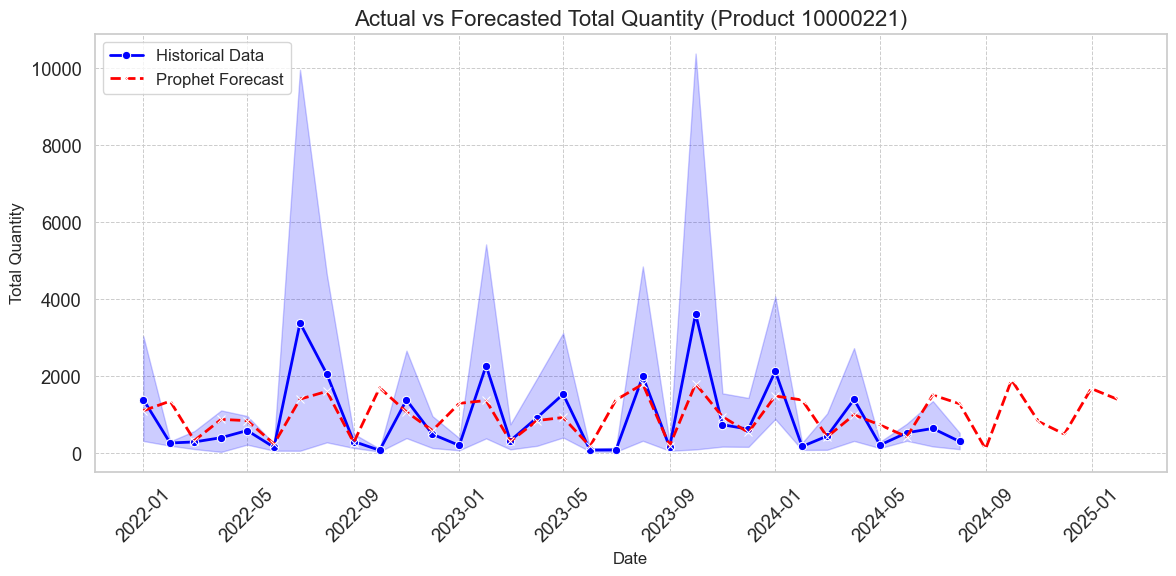

c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Abdur Raffay Khan\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future ve

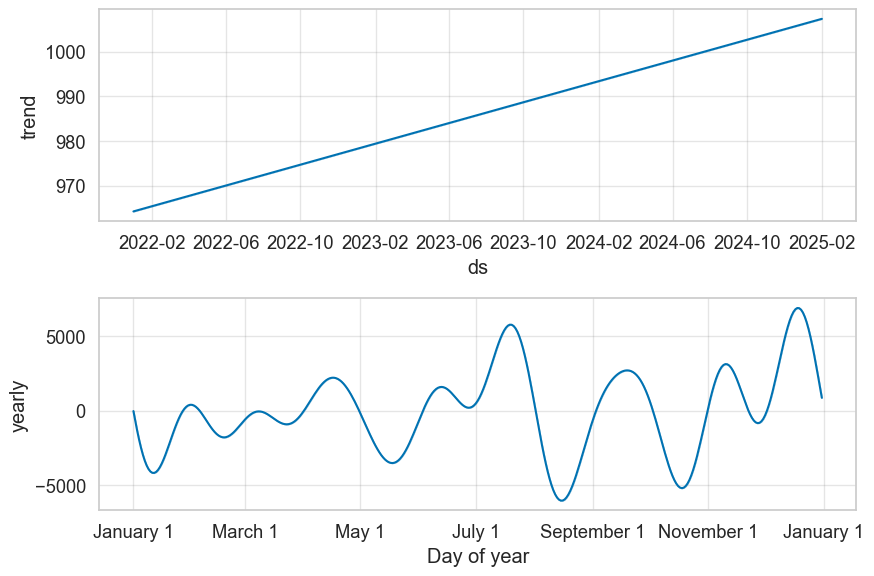

In [72]:
import gdown
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Set up seaborn for better plots
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Step 1: Download the dataset
file_url_10000221 = 'https://drive.google.com/uc?id=1WewnI4eMUlAJIB3YDriBkzW46qHkatqI'
gdown.download(file_url_10000221, 'dataset_10000221.csv', quiet=False)

# Load the dataset
df_10000221 = pd.read_csv('dataset_10000221.csv')

# Preprocessing
df_10000221['Year'] = df_10000221['Year'].astype(int)
df_10000221['Month'] = df_10000221['Month'].astype(int)
df_10000221['Date'] = pd.to_datetime(df_10000221['Year'].astype(str) + '-' + df_10000221['Month'].astype(str) + '-01', format='%Y-%m-%d')
df_10000221.set_index('Date', inplace=True)

# Prepare data for Prophet
prophet_df = df_10000221.reset_index()[['Date', 'Total_Quantity']]
prophet_df.columns = ['ds', 'y']

# Fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Forecast the next 6 months
future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast = prophet_model.predict(future)
forecast_df = forecast[['ds', 'yhat']].tail(6).set_index('ds')
forecast_df.columns = ['Prophet_Forecast']

# Plot results
plt.figure(figsize=(12, 6))
sns.lineplot(data=prophet_df, x='ds', y='y', label='Historical Data', color='blue', marker='o', linewidth=2)
sns.lineplot(data=forecast, x='ds', y='yhat', label='Prophet Forecast', color='red', linestyle='--', marker='x', linewidth=2)

# Customize the plot
plt.title('Actual vs Forecasted Total Quantity (Product 10000221)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Quantity', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

# Plot forecast components (trend, weekly, yearly seasonality)
prophet_model.plot_components(forecast)
plt.show()